# Building a fastText word vector based siamese LSTM model for computing comprehension scores for pairs of text

### 1. Import the libraries

In [62]:
# This Source Code Form is subject to the terms of the MPL
# License. If a copy of the same was not distributed with this
# file, You can obtain one at
# https://github.com/akhilpandey95/pubundsci/blob/master/LICENSE.

import os
import nltk
import random
import string
import spacy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from sklearn import metrics
from itertools import groupby
from nltk.collocations import *
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold
from nltk import word_tokenize as tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

### 2. Load the data

#### 2.1 Load the fastText word vector

In [ ]:
# load the fastText word embedding
nlp = sp.load('pubundsci_ft_wvec')

#### 2.2 Read the semeval training data and prepare the training dataset

In [6]:
# load semeval dataset
semeval_train_data = pd.read_csv('paragraph2sentence.train.input.tsv', sep='\t')
semeval_train_vals = pd.read_csv('paragraph2sentence.train.gs.tsv', sep='\t')

# create a defaultdict
train_data = defaultdict(dict)

# add the column containing the paragraphs
train_data['text_a'] = [semeval_train_data.columns[0] if x == 0 
                  else semeval_train_data[semeval_train_data.columns[0]][x] 
                  for x in range(len(semeval_train_data[semeval_train_data.columns[0]]))]

# add the column containing the sentences
train_data['text_b'] = [semeval_train_data.columns[1] if x == 0
                  else semeval_train_data[semeval_train_data.columns[1]][x]
                  for x in range(len(semeval_train_data[semeval_train_data.columns[1]]))]

# add the column containing the categories
train_data['cat'] = [semeval_train_data.columns[2] if x == 0
                  else semeval_train_data[semeval_train_data.columns[2]][x]
                  for x in range(len(semeval_train_data[semeval_train_data.columns[2]]))]

# add the column containing the similarity scores
train_data['sim_score'] = [semeval_train_vals.columns[0] if x == 0
                  else semeval_train_vals[semeval_train_vals.columns[0]][x]
                  for x in range(len(semeval_train_vals[semeval_train_vals.columns[0]]))]

# convert the dict to a dataframe
train_data = pd.DataFrame(train_data)

# add a new class label
# if sim_score is between 0.0 to 0.33, then pubund is 'low'
# if sim_score is between 0.33 to 0.66, then pubund is 'med'
# if sim_score is between 0.66 to 1.0, then pubund is 'high'
attach_pubund_label = lambda x: 'high' if float(x) > np.divide(2, 3) else 'med' if float(x) > np.divide(1, 3) and x < np.divide(2, 3) else 'low'

# apply the function
train_data = train_data.assign(pubund = [attach_pubund_label(x) for x in tqdm(train_data['sim_score'])])

# print the head of the data
train_data.head()

100%|██████████| 499/499 [00:00<00:00, 182854.94it/s]


,text_a,text_b,cat,sim_score,pubund
0,"Little St-Julien-le-Pauvre, a jewel of early G...",Bricks fired on the spot are the valley’s main...,Travel-1,0.00,low
1,Manzanillo initially drew the interest of inte...,"Nearby, on Calle Pío Rosado, the Museo Emilio ...",Travel-3,0,low
2,Alongside a landmark water tower is a good ope...,"Following a Mongol invasion, King Belá IV made...",Travel-4,2.5,high
3,Most beaches protected from the open ocean hav...,Boat cruises offer a care free way to enjoy th...,Travel-5,3,high
4,Shaolin offers one more treat for the more adv...,Visitors may ride a gondola to the mountain to...,Travel-6,2.5,high


#### 2.3 Normalize the sim_score column in the training data to a 0-1 range

In [7]:
# store the values of the scores into an array
x = train_data['sim_score'].values.astype(float)

# reshape the array
x = x.reshape(-1, 1)

# create a minmax processor object
min_max_scaler = MinMaxScaler()

# create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
train_data = train_data.assign(sim_score = x_scaled)

# print the head of the data
train_data.head()

,text_a,text_b,cat,sim_score,pubund
0,"Little St-Julien-le-Pauvre, a jewel of early G...",Bricks fired on the spot are the valley’s main...,Travel-1,0.000,low
1,Manzanillo initially drew the interest of inte...,"Nearby, on Calle Pío Rosado, the Museo Emilio ...",Travel-3,0.000,low
2,Alongside a landmark water tower is a good ope...,"Following a Mongol invasion, King Belá IV made...",Travel-4,0.625,high
3,Most beaches protected from the open ocean hav...,Boat cruises offer a care free way to enjoy th...,Travel-5,0.750,high
4,Shaolin offers one more treat for the more adv...,Visitors may ride a gondola to the mountain to...,Travel-6,0.625,high


#### 2.4 Read the semeval test data and prepare the test dataset

In [8]:
# load semeval dataset
semeval_test_data = pd.read_csv('paragraph2sentence.test.input.tsv', sep='\t')
semeval_test_vals = pd.read_csv('paragraph2sentence.test.gs.tsv', sep='\t')

# create a defaultdict
test_data = defaultdict(dict)

# add the column containing the paragraphs
test_data['text_a'] = [semeval_test_data.columns[0] if x == 0 
                  else semeval_test_data[semeval_test_data.columns[0]][x] 
                  for x in range(len(semeval_test_data[semeval_test_data.columns[0]]))]

# add the column containing the sentences
test_data['text_b'] = [semeval_test_data.columns[1] if x == 0
                  else semeval_test_data[semeval_test_data.columns[1]][x]
                  for x in range(len(semeval_test_data[semeval_test_data.columns[1]]))]

# add the column containing the categories
test_data['cat'] = [semeval_test_data.columns[2] if x == 0
                  else semeval_test_data[semeval_test_data.columns[2]][x]
                  for x in range(len(semeval_test_data[semeval_test_data.columns[2]]))]

# add the column containing the similarity scores
test_data['sim_score'] = [semeval_test_vals.columns[0] if x == 0
                  else semeval_test_vals[semeval_test_vals.columns[0]][x]
                  for x in range(len(semeval_test_vals[semeval_test_vals.columns[0]]))]

# convert the dict to a dataframe
test_data = pd.DataFrame(test_data)

# add a new class label
# if sim_score is between 0.0 to 0.33, then pubund is 'low'
# if sim_score is between 0.33 to 0.66, then pubund is 'med'
# if sim_score is between 0.66 to 1.0, then pubund is 'high'
attach_pubund_label = lambda x: 'high' if float(x) > np.divide(2, 3) else 'med' if float(x) > np.divide(1, 3) and x < np.divide(2, 3) else 'low'

# apply the function
test_data = test_data.assign(pubund = [attach_pubund_label(x) for x in tqdm(test_data['sim_score'])])

# print the head of the data
test_data.head()

100%|██████████| 499/499 [00:00<00:00, 215746.59it/s]


,text_a,text_b,cat,sim_score,pubund
0,Well what I want to know is that is it possibl...,I have heard that Verizon has the fastest spee...,CQA-1,1.25,high
1,"On a certain site, my friend was using my comp...",If I have set a website to never remember my p...,CQA-3,4,high
2,"OKay, so i am interested in blogging, although...",how do you know if your twitter account is bei...,CQA-4,0,low
3,The donations page for a legit church site tha...,How can i get rid of an image on imageshack wi...,CQA-5,0,low
4,I'm not looking to get rich or anything. I jus...,Online scams have been known to be very danger...,CQA-6,0.5,med


#### 2.5 Normalize the sim_score column in the test data to a 0-1 range

In [9]:
# store the values of the scores into an array
x = test_data['sim_score'].values.astype(float)

# reshape the array
x = x.reshape(-1, 1)

# create a minmax processor object
min_max_scaler = MinMaxScaler()

# create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
test_data = test_data.assign(sim_score = x_scaled)

# print the head of the data
test_data.head()

,text_a,text_b,cat,sim_score,pubund
0,Well what I want to know is that is it possibl...,I have heard that Verizon has the fastest spee...,CQA-1,0.3125,high
1,"On a certain site, my friend was using my comp...",If I have set a website to never remember my p...,CQA-3,1.0000,high
2,"OKay, so i am interested in blogging, although...",how do you know if your twitter account is bei...,CQA-4,0.0000,low
3,The donations page for a legit church site tha...,How can i get rid of an image on imageshack wi...,CQA-5,0.0000,low
4,I'm not looking to get rich or anything. I jus...,Online scams have been known to be very danger...,CQA-6,0.1250,med


#### 2.6 Visualize the train_data as a scatterplot

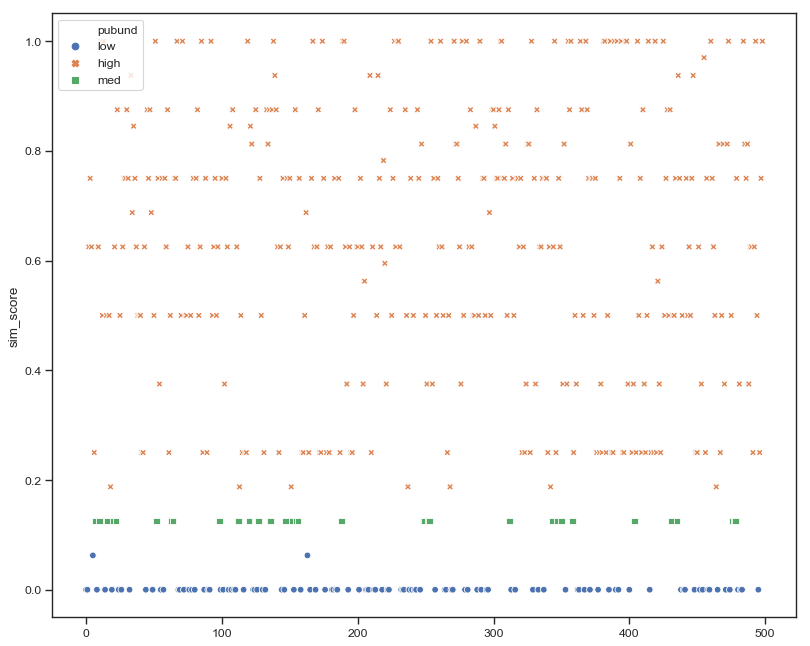

In [7]:
# set the sns style as ticks
sns.set(style='ticks')

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# load the scatterplot matrix
sns.scatterplot(y='sim_score', x=list(range(len(train_data))) ,data=train_data, style='pubund', hue='pubund')

#### 2.7 Visualize the test_data as a scatterplot

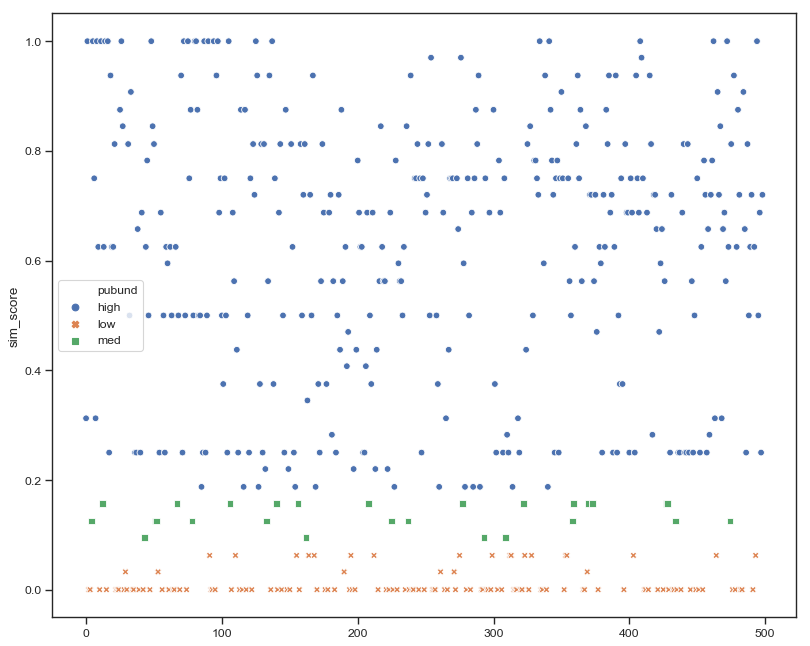

In [8]:
# set the sns style as ticks
sns.set(style='ticks')

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# load the scatterplot matrix
sns.scatterplot(y='sim_score', x=list(range(len(test_data))) ,data=test_data, style='pubund', hue='pubund')

### 3. Create a `tf` session and set model params 

In [ ]:
# init a tf session
sess = tf.Session()

# model parameters
batch_size = 200
num_batches = 300
max_address_len = 20
margin = 0.20
num_features = 50
dropout_keep_prob = 0.8

### 4. The Siamese LSTM model

#### 4.1 Class definition for the Sia_lstm model

In [ ]:
# @param_1 : pair_one
# @param_2 : pair_two
# @param_3 : dropout_keep_prob
# @param_4 : vocab_size
# @param_5 : num_features
# @param_6 : length
class siamese_lstm(object):
    # call the init function
    def __init__(self, config):
        # tf placeholders for input, output and dropout variables
        self.input_text_left = tf.placeholder(tf.int32, [None, config.seq_len], name='input_text_left')
        self.input_text_right = tf.placeholder(tf.int32, [None, config.seq_len], name='input_text_right')
        self.input_sim_score = tf.placeholder(tf.float32, [None], name='input_sim_score')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')
        
        # tf constant for l2 regularization loss
        l2_reg_loss = tf.constant(0.0, name='l2_reg_loss')
        
        # using fastText embedding Embedding layer
        with tf.name_scope('ft_word_embedding'):
            # variables for the embedding layer
            self.word = tf.Variable(
                tf.constant(0.0, shape=[config.vocab_size, config.embedding_size]),
                trainable=config.train_embeddings, name='word')
            self.emb_words_left = tf.nn.embedding_lookup(self.word, self.input_text_left)
            self.emb_words_right = tf.nn.embedding_lookup(self.word, self.input_text_right)
            
        # using a conv maxpool layer
        with tf.name_scope('output'):
            

#### 4.3. Helper functions for the LSTM model

In [ ]:
# function for loading vectors from a .vec file
def load_vec(file):
    # create an empty dict
    res = {}
    
    # open the file
    f = io.open(file, encoding='utf-8', newline='\n', errors='ignore')
    
    # map a integer over all the words
    n, d = map(int, f.readline().split())
    
    # look for tokens
    for line in f:
        tokens = line.rstrip().split(' ')
        res[tokens[0]] = map(float, tokens[1:])
    
    # return the vector representation
    return res

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

### 5. Feature engineering

#### 5.1 Functions for extracting linguistic features

In [38]:
# function for calculating words in a sentence
def words_in_sentence(sentence):
    w = [words.strip("0123456789!:,.?()[]{}") for words in sentence.split()]
    return filter(lambda x: len(x) > 0, w)

# function for computing yules i measure
def compute_yules_i_for_text(sentence):
    dictionary = {}
    stemmer = PorterStemmer()

    for word in words_in_sentence(sentence):
        word = stemmer.stem(word).lower()
        try:
            dictionary[word] += 1
        except:
            dictionary[word] = 1

    m1 = float(len(dictionary))
    m2 = sum([len(list(grouped_values)) * (frequency ** 2) for frequency, grouped_values in groupby(sorted(dictionary.values()))])

    # compute yules i and return the value
    try:
        yules_i = (m1 * m1) / (m2 - m1)
        return yules_i
    except ZeroDivisionError:
        return 0

# function for calculating trigrams and bigrams
def compute_collocation_score(sentence_one, sentence_two, option):
    if option == "bi":
        tokens_for_one = nltk.wordpunct_tokenize(sentence_one)
        tokens_for_two = nltk.wordpunct_tokenize(sentence_two)
        finder_one = BigramCollocationFinder.from_words(tokens_for_one)
        finder_two = BigramCollocationFinder.from_words(tokens_for_two)
        result_one = finder_one.score_ngrams(nltk.collocations.BigramAssocMeasures().raw_freq)
        result_one = [(tuple(map(str.lower, values)), scores) for values, scores in result_one]
        result_two = finder_two.score_ngrams(nltk.collocations.BigramAssocMeasures().raw_freq)
        result_two = [(tuple(map(str.lower, values)), scores) for values, scores in result_two]
        matches = [keys for keys in set(result_one).intersection(set(result_two))]
        return len(matches)
    elif option == "tri":
        tokens_for_one = nltk.wordpunct_tokenize(sentence_one)
        tokens_for_two = nltk.wordpunct_tokenize(sentence_two)
        finder_one = TrigramCollocationFinder.from_words(tokens_for_one)
        finder_two = TrigramCollocationFinder.from_words(tokens_for_two)
        result_one = finder_one.score_ngrams(nltk.collocations.TrigramAssocMeasures().raw_freq)
        result_one = [(tuple(map(str.lower, values)), scores) for values, scores in result_one]
        result_two = finder_two.score_ngrams(nltk.collocations.TrigramAssocMeasures().raw_freq)
        result_two = [(tuple(map(str.lower, values)), scores) for values, scores in result_two]
        matches = [keys for keys in set(result_one).intersection(set(result_two))]
        return len(matches)
    else:
        return 0
    
# function for removing stop words from a sentence
def remove_stopwords(text):
    stemmer =  PorterStemmer()
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in [stemmer.stem(words) for words in tokenize(text)] if w.lower() not in stopwords]
    return content

# function for calculating cosine similarity for a given pair of sentences
def cosine_sim(sentence_a, sentence_b):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(tuple([' '.join(remove_stopwords(sentence_a))]) + tuple([' '.join(remove_stopwords(sentence_b))]))
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)[0][1]

#### 5.2 Use functions from `5.1` for adding features to the training data

In [27]:
# add the column yules I for text a
train_data = train_data.assign(yules_i_text_a = 
            [compute_yules_i_for_text(x) for x in tqdm(train_data['text_a'])])

# add the column yules I for text b
train_data = train_data.assign(yules_i_text_b = 
            [compute_yules_i_for_text(x) for x in tqdm(train_data['text_b'])])

# add the column bi grams for (text_a, text_b)
train_data = train_data.assign(bigrams = 
            [compute_collocation_score(train_data['text_a'][x], train_data['text_b'][x], 'bi')
             for x in tqdm(range(len(train_data)))])

# add the column tri grams for (text_a, text_b)
train_data = train_data.assign(trigrams = 
            [compute_collocation_score(train_data['text_a'][x], train_data['text_b'][x], 'tri')
             for x in tqdm(range(len(train_data)))])

# add the cosine similarity between a and b
train_data = train_data.assign(cos_sim = 
            [cosine_sim(train_data['text_a'][x], train_data['text_b'][x])
             for x in tqdm(range(len(train_data)))])

# display the head of the training data
train_data.head()

100%|██████████| 499/499 [00:02<00:00, 184.97it/s]


,text_a,text_b,cat,sim_score,pubund,yules_i_text_a,yules_i_text_b,bigrams,trigrams,cos_sim
0,"Little St-Julien-le-Pauvre, a jewel of early G...",Bricks fired on the spot are the valley’s main...,Travel-1,0.000,low,42.250000,33.333333,0,0,0.000000
1,Manzanillo initially drew the interest of inte...,"Nearby, on Calle Pío Rosado, the Museo Emilio ...",Travel-3,0.000,low,26.414634,192.000000,0,0,0.000000
2,Alongside a landmark water tower is a good ope...,"Following a Mongol invasion, King Belá IV made...",Travel-4,0.625,high,52.900000,63.375000,0,0,0.348823
3,Most beaches protected from the open ocean hav...,Boat cruises offer a care free way to enjoy th...,Travel-5,0.750,high,38.223529,71.272727,0,0,0.175055
4,Shaolin offers one more treat for the more adv...,Visitors may ride a gondola to the mountain to...,Travel-6,0.625,high,14.802778,40.090909,0,0,0.278471


#### 5.3 Construct a scatterplot matrix on the training data

/Users/akhil/.pyenv/versions/jupyter/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/akhil/.pyenv/versions/jupyter/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/akhil/.pyenv/versions/jupyter/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


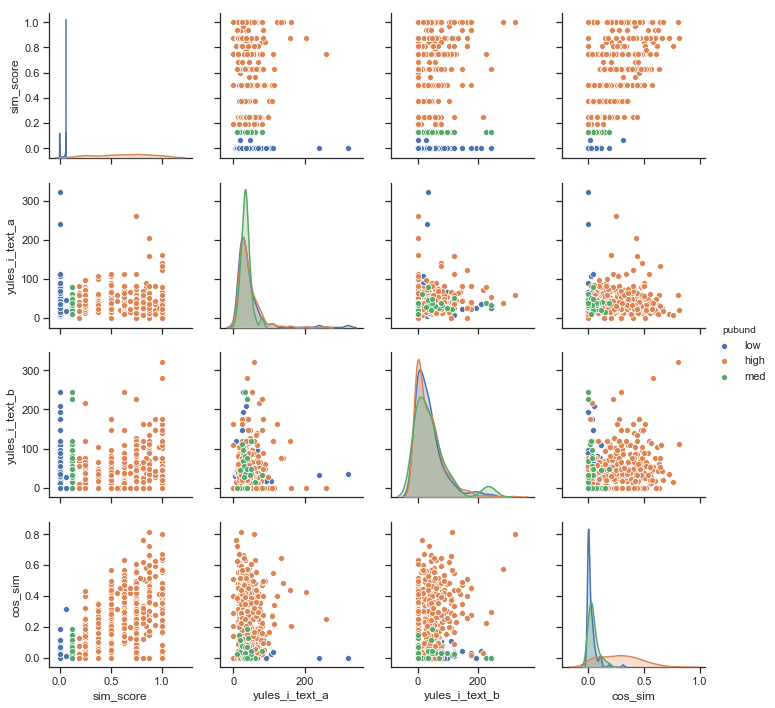

In [42]:
# set the sns style as ticks
sns.set(style='ticks')

# load the scatterplot matrix
sns.pairplot(train_data.iloc[:, [3, 4, 5, 6, 9]], hue='pubund')

#### 5.4 Use functions from `5.1` for adding features to the test data

In [26]:
# add the column yules I for text a
test_data = test_data.assign(yules_i_text_a = 
            [compute_yules_i_for_text(x) for x in tqdm(test_data['text_a'])])

# add the column yules I for text b
test_data = test_data.assign(yules_i_text_b = 
            [compute_yules_i_for_text(x) for x in tqdm(test_data['text_b'])])

# add the column bi grams for (text_a, text_b)
test_data = test_data.assign(bigrams = 
            [compute_collocation_score(test_data['text_a'][x], test_data['text_b'][x], 'bi')
             for x in tqdm(range(len(test_data)))])

# add the column tri grams for (text_a, text_b)
test_data = test_data.assign(trigrams = 
            [compute_collocation_score(test_data['text_a'][x], test_data['text_b'][x], 'tri')
             for x in tqdm(range(len(test_data)))])

# add the cosine similarity between a and b
test_data = test_data.assign(cos_sim = 
            [cosine_sim(test_data['text_a'][x], test_data['text_b'][x])
             for x in tqdm(range(len(test_data)))])

# display the head of the test data
test_data.head()

100%|██████████| 499/499 [00:02<00:00, 192.25it/s]


,text_a,text_b,cat,sim_score,pubund,yules_i_text_a,yules_i_text_b,bigrams,trigrams,cos_sim
0,Well what I want to know is that is it possibl...,I have heard that Verizon has the fastest spee...,CQA-1,0.3125,high,23.296970,30.083333,0,0,0.052436
1,"On a certain site, my friend was using my comp...",If I have set a website to never remember my p...,CQA-3,1.0000,high,19.692308,24.083333,0,0,0.458148
2,"OKay, so i am interested in blogging, although...",how do you know if your twitter account is bei...,CQA-4,0.0000,low,34.215517,0.000000,0,0,0.033926
3,The donations page for a legit church site tha...,How can i get rid of an image on imageshack wi...,CQA-5,0.0000,low,112.666667,48.000000,0,0,0.056644
4,I'm not looking to get rich or anything. I jus...,Online scams have been known to be very danger...,CQA-6,0.1250,med,41.263158,133.333333,0,0,0.037870


#### 5.5 Construct a scatterplot matrix on the test data

/Users/akhil/.pyenv/versions/jupyter/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


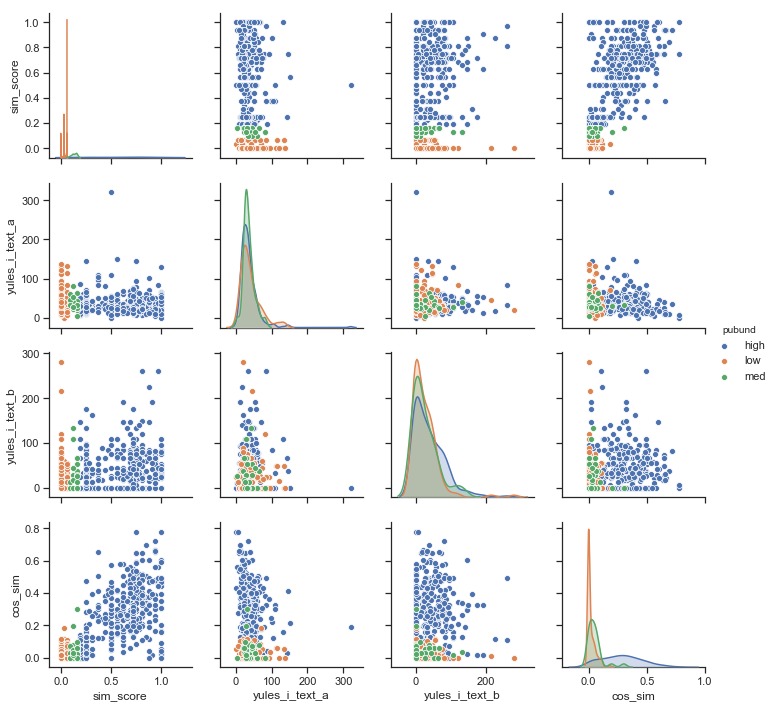

In [41]:
# set the sns style as ticks
sns.set(style='ticks')

# load the scatterplot matrix
sns.pairplot(test_data.iloc[:, [3, 4, 5, 6, 9]], hue='pubund')

### 6. Data preparation for regression and classification experiments

In [55]:
# x_train, x_test, y_train, y_test
train_data_array = train_data.iloc[:, [5, 6, 9]].values
train_class_array = train_data['pubund'].values
test_data_array = test_data.iloc[:, [5, 6, 9]].values
test_class_array = test_data['pubund'].values

### 7. Classification models

#### 7.1 Fit a Random Forest Classifier

In [67]:
# Random Forest classifier
rf = RandomForestClassifier()

# 10 fold validation split
kf = KFold(n_splits=10, random_state = 42, shuffle=False)
val_errors = []
train_errors = []

# test train split
for train_index, val_index in kf.split(train_data_array):
    X_train, X_val = train_data_array[train_index], train_data_array[val_index]
    y_train, y_val = train_class_array[train_index], train_class_array[val_index]
    rf.fit(X_train, y_train)
    val_pred = rf.predict(X_val)
    train_pred = rf.predict(X_train)
    val_errors.append(metrics.accuracy_score(y_val, val_pred))
    train_errors.append(metrics.accuracy_score(y_train, train_pred))

# train again on the entire data
rf.fit(train_data_array, train_class_array)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### 7.2 Display feature importance table for `rf` classifier

In [68]:
pd.DataFrame(rf.feature_importances_)

,0
0,0.303406
1,0.120352
2,0.576242


#### 7.3  Train accuracy, validation accuracy & test accuracy for `rf` model

In [69]:
# Mean in sample accuracy score with 95% CI
score = cross_val_score(rf, X_train, y_train, cv=10)
print("In sample accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# Mean out of sample accuracy score with 95% CI
score = cross_val_score(rf, X_val, y_val, cv=10)
print("Out of sample accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# accuracy
pred = rf.predict(test_data_array)
score = metrics.accuracy_score(test_class_array, pred)
print("Test Accuracy:   %0.3f" % score)

In sample accuracy: 0.78 (+/- 0.11)
Out of sample accuracy: 0.80 (+/- 0.36)
Test Accuracy:   0.792


/Users/akhil/.pyenv/versions/jupyter/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
